###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1

Name: Sina Eghbal

Student ID: u5544352

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 19|
|Weight|19% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 20%. No assignments shall be accepted if it is later than 5 days. | 
| Cooperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

Setting up the environment (Please evaluate this cell to activate the $\LaTeX$ macros.)

In [1]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)

%matplotlib inline

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [3]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


In [4]:
print (features)
print (target)

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
>50K



X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446


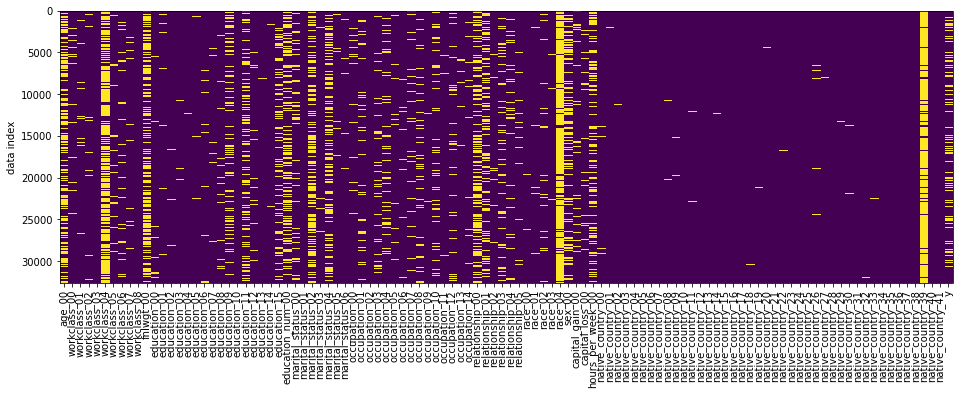

In [5]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]

## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.

### <span style="color:blue">Answer</span>
<i></i>

- Independence Assumption
$$P(\mathbf{X} | C) = P (<x_1, x_2, ..., x_d> | C)=\Pi_{i=1}^{d}P (x_i|C)$$

This means that given a class, the probability of a point (represented by a feature vector) belonging to that class is equal to the multiplication of the probability of the same value for the same feature belonging to that class.

This implies that features are independent from each other as each feature have their own p values given a class.

- Maximum Likelihood

$$\argmax_{\theta} L (\theta|D)$$

> or in other words

$$\argmax_{\theta} P (D| \theta)$$

> Which is adjusting the parameters to maximise the likelihood.
To do this for the given problem, we want to maximise the probability of our classifier correctly classifying our datapoints and $\theta$ (parameters that we want to adjust) are $\mu$ and $\rho$.

> So we can use bayes rule to write our classifier in terms of $P (\textbf{X}|C_k)$ and $P (C_k)$.

$$P (C_k|\mathbf{X}) = \frac{P (\mathbf{X}|C_k)P (C_k)}{P(\mathbf{X})}$$

>Since we are taking the argmax based on $\mu$ and $\rho _{j,k}$ we can ignore $P(\mathbf{X})$
Therefore:

$$P (C_k|\mathbf{X}) \propto P (\mathbf{X}|C_k)P (C_k)$$

> Also since we have

$$P(y=1)=\mu \rightarrow P (y=0) = 1-\mu$$

> we can write $\mu ^{y^{(i)}}$ to activate $\mu$ when $P(y=1)$ and write $1-\mu^{1-y^{(i)}}$ to activate $P(y=0)$ when $y=0$

>Finally, we can represent $P(x_j=0|C=k)$ as $1-\rho_{j,k}$ and activate it by raising it to the power of the single binary feature we are looking at, namely $1-x^{(i)}_j$

>Hence we can write our likelihood function; $P (C|\mathbf{X})$ as:

$$P (C|\mathbf{X}) \propto\mu^k.(1-\mu)^{1-k}\Pi_{j=1}^{d} \rho_{j, k}^{x_j}(1-\rho_{j, k})^{1-x_j}$$

>Since we will be taking the gradient to find the argmax, taking the log will let us simplify the computation
[//]: <> ($$l(\theta)=\Sigma_{i=1}^n [y^{(i)}\log{\mu} + (1-y^{(i)})\log{(1-\mu)}] + \Sigma_{i=1}^{n}\Sigma_{i=1}^{d}[x_j^{(i)}\log{\rho_{j,k}}+(1-x_j^{(i)})\log{(1-\rho_{j,k})}]$$)

$$L(\theta) = k\log{\mu}+(1-k)\log{(1-\mu)}+\Sigma_{j=1}^d[x_j\log{\rho_{j,k}+(1-x_j)\log{(1-\rho_{j,k})}}]$$

>To take $argmax_\mu$ we take the derivative of $l$ w.r.t to $\mu$
$$\frac{dl}{d\mu}=\Sigma_{i=1}^{n}[\frac{y^{(i)}}{\mu} - \frac{1-y^{(i)}}{1-\mu}]$$

>and then let it be zero which gives us:

$$\frac{\text{# of 1s in targets}}{\text{probability of point belonging to }C_1} = \frac{\text{# of 0s in targets}}{\text{probability of point belonging to }C_0}$$

>In other words

$$\frac{\text{# of 1s in target vals}}{\mu}=\frac{\text{# of 0s in target vals}}{1-\mu}$$

>Or even simpler

$$(1-\mu)\text{ count}(1s)=\mu\text{ count}(0s)\therefore$$

>So looking at the target vector, we can calculate $\mu$ using the following formula

$$\mu_{ML}=\frac{\text{count}(1s)}{n}$$

>Now we take the derivative w.r.t $\rho_{j,k}$

$$\frac{dl}{d\rho_{j,k}}=\Sigma_{i=1}^n\Sigma_{j=1}^d[\frac{ x_j^{(i)}}{\rho_{j,k}}-\frac{1- x_j^{(i)}}{1-\rho _{j,k}}]$$

>Assigning the above equation to zero will give us

$$\Sigma_{i = 1}^n\Sigma_{j = 1}^d [(1-\rho_{j,k}) \text{count(1s)}-\rho_{j,k}(n-\text{count(1s)})]=0$$
[//]: <> (or in other words $$\frac{\text{count}(1s)}{P(x=1|y=k)}=\frac{\text{count}(0s)}{P(x=0|y=k)}\therefore\frac{\text{count}(1s)}{\rho_{j,k}}=\frac{\text{count}(0s)}{(1-\rho_{j,k})}$$)

> Which for each $j$ and $k$ gives us

$$\rho_{j,k \textbf{ML}} = \frac{\text{count}(x_j=1)\text{ when } C = k}{\text{Count} (C = k)}$$

> That is, for $\rho_{j,k}$ we are looking at all the point beloning to class $k$ and counting the number of occurences of 1 in $x_j$ and dividing it by the number of observed points.

> Or in other words

$$\rho_{j, k} = \frac {\text{number of }x_j=1\text{s when } C= k}{\text{number of points where }C = k}$$

In [6]:

def calculate_mu_ml (data):
    """
    This function calculates and returns \mu_ml
    To be called on the training labels
    """
    return np.count_nonzero (data)/data.shape[0]

def calculate_rho_ml (data, targets):
    """
    Calculates rho ml using the training data and targets
    returns a numpy array with two rows; each representing tho row values for a label
    and each column representing the probabiliry of a feature being 1 for the particular label
    """
    no_features = data.shape [1]
    rho_j_k = np.empty ([2, no_features])
    one_targets = np.count_nonzero (targets)
    one_targets_indices = np.where (targets == 1)[0]
    zero_targets = targets.shape[0] - one_targets
    zero_targets_indices = np.where (targets == 0)[0]
    for feature in range (0, no_features):
        rho_j_k [0,feature] = sum (data [zero_targets_indices,feature])/zero_targets
        rho_j_k [1,feature] = sum (data [one_targets_indices,feature])/one_targets
    return rho_j_k

Indices of zero values in rho_m_l
[  4   9  29  37  69  71  72  75  80  85  86  90  93  99 103   4   9  13
  14  15  24  31  37  44  66  69  72  77  78  79  80  81  82  83  88  89
  90  91  92  93  94  96  97  98  99 100 101 102 103 105 106]


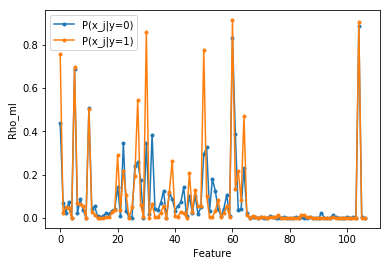

In [7]:
# Let's calculate mu_ml and rho_ml values
mu_ml = calculate_mu_ml (Y_train)

rho_ml = calculate_rho_ml (X_train, Y_train)
print ("Indices of zero values in rho_m_l")
print (np.where (rho_ml == 0)[1])

plt.plot (rho_ml[0], marker= '.', label = "P(x_j|y=0)")
plt.plot (rho_ml[1], marker= '.', label = "P(x_j|y=1)")
plt.ylabel ("Rho_ml")
plt.xlabel ("Feature")
plt.legend()

Since we are performing our calculation using the $\rho_{j,k}$ values, by our independence assumption having a $\rho_{j,k}=0$ means that $p(X|C=k)$ will always be $0$ regardless of other features.
Also a value $\rho_{j,k}=1$ for some j means $\rho_{j',k}=0$ when $x_j = 0$.

## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
To calculate MAP we want to take the **argmax**$P (\theta|D)$ over $\mu$ and $\rho_{j,k}$
By bayes rule we have:
$$P (\theta|D) = \frac{P (D|\theta)P(\theta)}{P (D)}$$

And since $P (D)$ is only dependent data, we can ignore it when taking the **argmax** over $\mu$ and $\rho_{j,k}$

As we calculated in the last question

$$P (\mathbf{D}|\theta) = \Pi_{i = 1}^{n}\Pi_{j=1}^{d} \rho_{j, k}^{X_j^{(i)}}\mu^{y^{(i)}}(1-\rho_{j, k}^{X_j^{(i)}})\mu^{1-y^{(i)}}$$

To calculate our expression proportional to $P (\theta|D)$ we multiply the above expression by our prior.

[//]: <> ($$P (\theta|D) \propto \Pi_{i=1}^{n}\Pi_{j=1}^{d}[\rho_{j, k}^{X_j^{(i)}}\mu^{y^{(i)}}(1-\rho_{j, k}^{X_j^{(i)}})\mu^{1-y^{(i)}}]\Pi_{j=1}^{d}\frac{\rho_{j,k}^{\beta-1}(1-\rho_{j,k})^{\beta-1}}{Z (B)}$$)

$$P (\theta|D) \propto \Pi_{i=1}^{n}\Pi_{j=1}^{d}[\rho_{j, k}^{X_j^{(i)}}\mu^{y^{(i)}}(1-\rho_{j, k}^{X_j^{(i)}})\mu^{1-y^{(i)}}]\frac{\rho_{j,k}^{\beta-1}(1-\rho_{j,k})^{\beta-1}}{Z (B)}\times\frac{1}{\mu}$$

To get the **argmax** we use log likelihood.

[//]: <> ($$l \propto \Sigma_{i=1}^{n}[y^{(i)}\log{\mu} + (1-y^{(i)})\log{(1-\mu)}] + \Sigma_{i=1}^{n}\Sigma_{i=1}^{d}[x_i\log{\rho_{j,k}} + (1-x_i)\log{(1-\rho_{j,k})}] + \Sigma_{j=1}^{d}[(\beta -1)(\log{\rho_{j,k}}+\log{(1-\rho_{j,k}))}]-dZ(B)$$)

$$l \propto \Sigma_{i=1}^{n}[k\log{\mu}+(1-k)\log{(1-\mu)}]+\Sigma_{j=1}^d[x_j\log{\rho_{j,k}+(1-x_j)}] + \Sigma_{j=1}^{d}[(\beta -1)(\log{\rho_{j,k}}+\log{(1-\rho_{j,k}))}]-dZ(B)-\log{(\mu)}$$

** appologies for the bad notation; $k$ is the label for the particular target. This could be better represented with $C_k$

Taking the log w.r.t $\mu$ gives us the following expression and let it equal $0$

$$\Sigma_{i=1}^n[\frac{k}{\mu}-\frac{1-k}{1-\mu}]-\frac{1}{u}$$

Which gives us:

$$\frac{\text{Count}(1s)-1}{\mu}-\frac{\text{Count}(0s)}{1-\mu}$$

$$\mu (\text{Count}(0s) + \text{Count}(1s) - 1) - \text{Count}(1s) + 1 = 0$$
[//]: <> ($$\text{Count}(1s) - \mu\text{Count}(1s) + 1 - \mu - \text{Count}(0s)\mu = 0$$)

$$\mu_{MAP} = \frac{\text{Count}(1s) - 1}{n - 1}$$

To derive $\rho_{j,k \textbf{MAP}}$ we calculate $\frac{dl}{d\rho_{j,k}}$

[//]: <> ($$\frac{dl}{d\rho_{j,k}} = \Sigma_{i=1}^{n}\Sigma_{j=1}^{d}[\frac{x_j^{(i)}}{\rho_{j,k}}-\frac{1-x_j^{(i)}}{1-\rho _{j,k}}] + \Sigma_{j = 1}^{d}[((\frac{\beta -1}{\rho_{j,k}} - \frac{\beta-1} {(1-\rho_{j,k})}))]$$)

$$\frac{dl}{d\rho_{j,k}} = \Sigma_{i=1}^{n}[\frac{x_j^{(i)}}{\rho_{j,k}}-\frac{1-x_j^{(i)}}{1-\rho _{j,k}}] + (\frac{\beta -1}{\rho_{j,k}} - \frac{\beta-1} {(1-\rho_{j,k})})$$

And setting it equal to zero for every feature vector gives us:

[//]: <> ($$d\beta-d-\rho\beta+\rho d-\rho d \beta + \rho d + \text{Count(1s)}-d\rho=0$$)
$$\text{Count}(1s)-\text{Count}(1s)\rho_{j,k}-\rho_{j,k}.n+\text{Count}(1s)\rho_{j,k}+\beta-1-2\rho_{j,k}\beta+2\rho_{j,k}$$

[//]: <> ($$\Sigma_{j=1}^{d}\frac{x_j^{(i)} - \rho_{j,k}x_j^{(i)} - \rho_{j,k} + \rho_{j,k}x_j^{(i)} + \beta - \beta\rho_{j,k}-1+\rho_{j,k}-\beta\rho_{j,k} + \rho_{j,k}}{\rho_{j,k}(1-\rho_{j,k})}$$)

And therefore we can write $\rho_{j,k \textbf{MAP}}$ as

[//]: <> ($$\Sigma_{i=1}^{n}\rho_{j,k}(1-2\beta) = \Sigma_{j=1}^{d}1-(\beta-x_j)\therefore$$)
[//]: <> ($$\rho_{j,k \textbf{MAP}}=\frac{d-d\beta-\Sigma_{j=1}^dx_j}{d(1-2\beta)}= \frac{d-d\beta-\text{Count(1s)}}{d(1-2\beta)}$$)

$$\rho_{j,k \textbf{MAP}}=\frac{-\text{Count}(1s\text{ where } t == k)-\beta+1}{-\text{Count}(t = k)-2\beta+2}$$

In [8]:
def calculate_mu_map (data):
    """
    This function calculates and returns \mu_map
    To be called on the training labels
    """
    return (np.count_nonzero (data) - 1)/(data.shape[0] - 1)

def calculate_rho_map (data, targets, beta):
    """
    Calculates rho_map using the training data, targets, and a beta value
    returns a numpy array with two rows; each representing tho row values for a label
    and each column representing the probabiliry of a feature being 1 for the particular label
    """
    no_features = data.shape [1]
    rho_j_k = np.empty ([2, no_features])
    one_targets = np.count_nonzero (targets)
    one_targets_indices = np.where (targets == 1)[0]
    zero_targets = targets.shape[0] - one_targets
    zero_targets_indices = np.where (targets == 0)[0]
    for feature in range (0, no_features):
        rho_j_k [0,feature] = (sum (data [zero_targets_indices,feature]) + beta - 1)/(zero_targets + (2 * beta) - 2)
        rho_j_k [1,feature] = (sum (data [one_targets_indices,feature]) + beta - 1)/(one_targets + (2 * beta) - 2)
    return rho_j_k

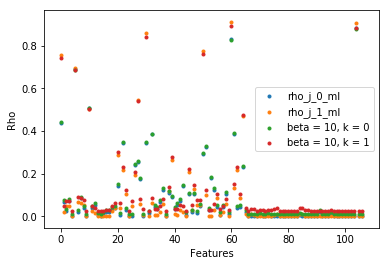

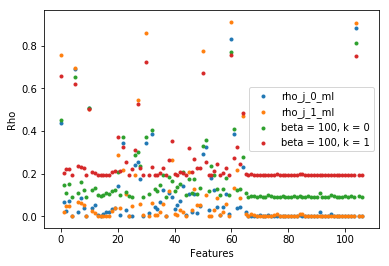

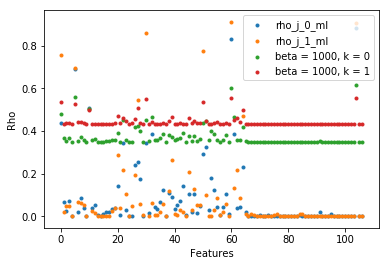

In [9]:
# rho_ml and rho_map should be equal given beta = 1 for rho map
assert np.allclose (calculate_rho_map (X_train, Y_train, beta = 1), rho_ml)

betas = list ([10, 100, 1000])

# Let's plot and see how do our rho values change when we increase our beta values.
for beta in betas:
    rho_map = calculate_rho_map (X_train, Y_train, beta)
    x_vals = list (range (len (rho_map[1])))
    plt.figure ()
    plt.scatter (x = x_vals, y = rho_ml[0], marker = '.', label = 'rho_j_0_ml')
    plt.scatter (x = x_vals, y = rho_ml[1], marker = '.', label = 'rho_j_1_ml')
    plt.scatter (x = x_vals, y = rho_map[0], marker = '.', label = 'beta = %i, k = 0' % (beta))
    plt.scatter (x = x_vals, y = rho_map[1], marker = '.', label = 'beta = %i, k = 1' % (beta))
    plt.xlabel ("Features")
    plt.ylabel ("Rho")
    plt.legend()

> So the greater the $\beta$ be, the probabilities will converge and get closer to 0.5 and the range in which probabilities appear will be smaller.

> One use of beta can be to get rid of $0$ values in the denominator when we're calculating $\rho_{j,k}$

## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>
Given a data point $\mathbf{x}$ we want to find the probability of it, belonging to class **1**
By Bayes rule we get:
$$P (y = 1 | \mathbf{x}, {\rho_{j,k}}, \mu)=\frac {P (\mathbf{x} | y = 1, {\rho_{j,k}}, \mu)P (y=1|{\rho_{j,k}}, \mu)}{P (\mathbf{x}| {\rho_{j,k}}, \mu )}$$

Also using sum rule, we can rewrite the above expression as

$$\frac {P (\mathbf{x}| y = 1, {\rho_{j,k}}, \mu)P (y=1| {\rho_{j,k}}, \mu )}{P (\mathbf{x} | y = 0, {\rho_{j,k}}, \mu)(1-\mu) + P (\mathbf{x}| y = 1, {\rho_{j,k}}, \mu)\mu}$$

[//]: <> (Using the independence assumption and $\mu$ we get $$\frac{\mu\Pi_{j=1}^dP(x_j|y=1)}{\mu\Pi_{j=1}^dP(x_j|y=1)+(1-\mu)\Pi_{j=1}^dP(x_j|y=0)}$$)

By applying the independence assumption and $\rho_{j,k}$ we can write the above formula as:

$$\mu\frac{\Pi_{j=1}^d[\rho_{j,1}^{x_j} . (1-\rho_{j,1})^{1-x_j}]}{\mu\Pi_{j=1}^d[\rho_{j,1}^{x_j}.(1-\rho_{j,1})^{(1-x_j)}] + (1-\mu)\Pi_{j=1}^d[\rho_{j,0}^{x_j}(1-\rho_{j,0})^{(1-x_j)}]}$$

Finally taking the logarithm gives us

$$\log{\mu}+\Sigma_{j=1}^d [x_j\log{(\rho_{j,1})} + (1-x_j)\log{(1-\rho_{j,1})}]-\log{(\mu\Pi_{j=1}^d[\rho_{j,1}^{x_j}.(1-\rho_{j,1})^{(1-x_j))} + (1-\mu)\Pi^d_{j=1}[\rho_{j,0}^{x_j}.(1-\rho_{j,0})^{(1-x_j)}}]]$$

In [10]:
def predictive_distribution (X, rho, mu):
    """
    Given an array of datapoints, an array representing our rho_j_k value and a mu,
    this functions returns the log probability of our point belonging to Class 1.
    """
    index = 0
    numerator = np.log (mu)
    exp_1 = np.log (mu)
    exp_2 = np.log (1 - mu)
    for feature in X:
        if feature:
            numerator += np.log (rho[1, index])
            exp_1 += np.log (rho [1, index])
            exp_2 += np.log (rho [0, index])
        else:
            numerator += np.log (1 - rho[1, index])
            exp_1 += np.log (1 - rho [1, index])
            exp_2 += np.log (1 - rho [0, index])
        index += 1
    denominator = np.logaddexp (exp_1, exp_2)
    result = numerator - denominator
    
    return result

In [11]:
rho = calculate_rho_map (X_train, Y_train, beta = 2)
mu = calculate_mu_map (Y_train)

def calculate_predictive_dist (X_test, rho, mu):
    """
    This promotes our predictive distribution function by taking a data matrix and calling
    the 'predictive_distribution' function on every single point.
    Returns the results as a numpy array each point representing one probability.
    """
    nrow = X_test.shape[0]
    classes = np.empty (nrow)
    for row in range (0, nrow):
        classes [row] = predictive_distribution (X_test[row], rho, mu)
    return classes

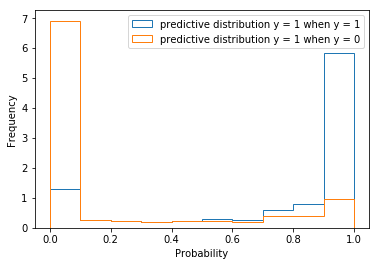

In [12]:
# Calculate the predictive distributions for X_test
classes = calculate_predictive_dist (X_test, rho, mu)
indices_1 = np.where (Y_test == 1)[0]
indices_0 = np.where (Y_test == 0)[0]
points_y_1 = np.exp (classes) [indices_1]
points_y_0 = np.exp (classes) [indices_0]

# And finally let's plot our histrograms.
plt.hist (points_y_1, normed=True, histtype='step', label='predictive distribution y = 1 when y = 1')
plt.hist (points_y_0, normed=True, histtype='step', label='predictive distribution y = 1 when y = 0')
plt.legend ()
plt.xlabel ("Probability")
plt.ylabel ("Frequency")

## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

### <span style="color:blue">Answer</span>

In [13]:
def evaluate (X, Y, rho, mu):
    """
    This function gets the features and labels for our test sets and uses the "calculate_predictive_dist"
    to calculate the probabilities for all our points and returns the mean probability of our points belonging
    to their given class estimated by our classifier and percentage of the correctly classified points.
    """
    predictive_dist_1 = np.exp (calculate_predictive_dist (X, rho, mu))
    predictive_dist_0 = 1 - predictive_dist_1
    mean_logp_true = np.mean (np.append (predictive_dist_1 [Y.squeeze() == 1], predictive_dist_0 [Y.squeeze() == 0]))

    classified_0 = predictive_dist_0 > 0.5
    classified_1 = predictive_dist_1 > 0.5
    percent_correct = np.count_nonzero (np.append (np.logical_and (classified_0.squeeze (), (Y == 0).squeeze()),
                                        np.logical_and (classified_1.squeeze (), (Y == 1).squeeze ())))/np.prod (Y.shape)
    
    result = dict ()
    
    result ["mean_logp_true"] = mean_logp_true
    result ["percent_correct"] = percent_correct
    return result

In [14]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

In [15]:
def cross_validate (beta, nfolds, X, Y):
    """
    Divides the data into n folds and train the n different classifier every time by excluding one of the
    slices and using that as the test set to measure the performance of the classifier.
    Returns a dictionaty taking the average of all the results.
    """
    length = X.shape[0]
    mean_logp_true = list ()
    percent_correct = list ()
    
    index_sets = xval_inds (length, nfolds)
    for i in range (0, nfolds):
        test_indices = index_sets [i][1]
        training_indices = index_sets [i][0]
        test_data = X [test_indices]
        test_labels = Y [test_indices]
        training_data = X [training_indices]
        training_labels = Y [training_indices]
        rho = calculate_rho_map (training_data, training_labels, beta)
        mu = calculate_mu_map (training_labels)
        current_result = evaluate (test_data, test_labels, rho, mu)
        mean_logp_true.append (current_result ["mean_logp_true"])
        percent_correct.append (current_result ["percent_correct"])
    result = dict()
    result ["mean_logp_true"] = np.mean (mean_logp_true)
    result ["percent_correct"] = np.mean (percent_correct)
    return result

In [16]:
betas = np.logspace(np.log10(2),2,32)

mean_logp_true_cv = list ()
percent_correct_cv = list ()
mean_logp_true_test_set = list ()
percent_correct_test_set = list ()

# Goes through all beta values and calls cross validation on them.
for beta in betas:
    current_result = cross_validate (beta, 11, X_test, Y_test)
    mean_logp_true_cv.append (current_result ["mean_logp_true"])
    percent_correct_cv.append (current_result ["percent_correct"])
    mu = calculate_mu_map (Y_train)
    rho = calculate_rho_map (X_train, Y_train, beta)
    current_result_eval = evaluate (X_test, Y_test, rho, mu)
    mean_logp_true_test_set.append (current_result_eval ["mean_logp_true"])
    percent_correct_test_set.append (current_result_eval ["percent_correct"])

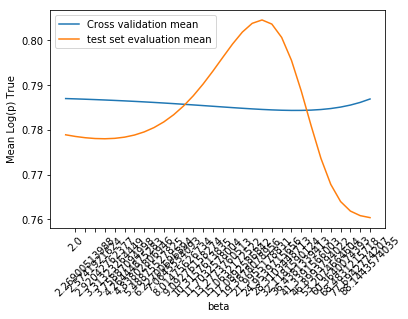

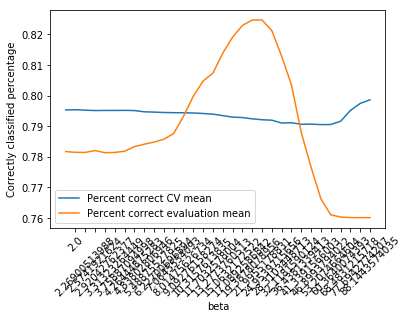

In [17]:
# Let's plot the percentage and mean probability of being correctly classified
xs_string = list (betas)
plt.plot (mean_logp_true_cv, label = "Cross validation mean")
plt.plot (mean_logp_true_test_set, label = "test set evaluation mean")
plt.xticks (range (1, len (xs_string)), xs_string, rotation = 45)
plt.legend ()
plt.xlabel ("beta")
plt.ylabel ("Mean Log(p) True")
plt.figure ()
plt.plot (percent_correct_cv, label = "Percent correct CV mean")
plt.plot (percent_correct_test_set, label = "Percent correct evaluation mean")
plt.xticks (range (1, len (xs_string)), xs_string, rotation = 45)
plt.legend ()
plt.xlabel ("beta")
plt.ylabel ("Correctly classified percentage")

## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>
1.
> **a.**  For the continuous variables we're comparing their values to the median which makes our feature dependent on our data. Hence analysing two different datasets can result in different meaning for the same features since the median will be likely to change and so the meaning of that feature.

> **b.**  For the discrete features we are creating as many binary features as there are values. This implies that our features will depend on each other while in Naive bayes we assume that our features are independent.

2.
> - For our categorical features, we can represent them as $\log_2{(\text{# of possible values})}$ instead of # of possible values (This may be unsuccessful due to the independence assumption of Naive Bayes).


> - To convert the continous features into binary features we can apply unsupervised learning to split the points into two clusters.


> - We can represent all our features using bits; i.e. boolean instead of float


> - Since all the features have the same weight, some features may be better weeded out before training.

3.
> - Since we have 3 binary variables and they might be dependent, we need a parameter for each state of every variable so we will have $2^3$ parameters. However, we can always represent the distribution using one fewer paramenter as one state can be represented using sum rule and the other states. Hence we only need $7$ parameters.


> - For the above factorisation we need $2$ parameters to represent each conditional probability. For instance one for $p (a | c)$ and another for $p (a | c')$. We also need $1$ parameter to represent the marginal probabilities therefore we need $5$ parameters to represent our distribution.

## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer</span>


> We know that the dot product of two orthogonal vectors is $0$. Since $\mathbf{w_\perp}$ is orthogonal to $\Sigma_{n=1}^N\alpha_n\phi(\mathbf{x}_n)$ we have

[//]: <> ($$\mathbf{w}_\perp^{T} .\mathbf{w} = 0$$)
$$\mathbf{w}_\perp^{T}a_n\phi(\mathbf {x_n}) = 0$$

[//]: <> (> By extending $\mathbf{w}$ we get: $$\Sigma_{n=1}^{N}\mathbf{w}_\perp^{T}a_n\phi(\mathbf {x_n}) + \mathbf{w}_\perp^{T}.\mathbf{w_\perp} = 0$$)

> Since $a_n$s are scalers that let us represent our model $a_n = 0$ is meaningless, hence we know that for each $\mathbf {x}$

$$\mathbf{w}_\perp^{T}\phi(\mathbf {x_n}) = 0$$

> So rewriting $J$ and expanding $\mathbf{w}$ we get

$$J(\mathbf{w}) = f((\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_1), \ldots, (\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_N)) + g((\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp)^\top . (\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp))$$

> And then since $\mathbf{w}_\perp^{T}\phi(\mathbf {x_n}) = 0$ we can simplify it to

$$J (\mathbf{w})  = f (\sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n).\phi (\mathbf{x}_1), \ldots, \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n).\phi (\mathbf{x}_n)) + g ((\sum_{n=1}^{N}a_n\phi(\mathbf{x_n}))^T.(\sum_{n=1}^{N}a_n\phi(\mathbf{x_n})) + \mathbf{w}_\perp^{T}.\mathbf{w}_\perp)$$

> This implies that to minimise $J$ we need to minimise $g ((\sum_{n=1}^{N}a_n\phi(\mathbf{x_n}))^T.(\sum_{n=1}^{N}a_n\phi(\mathbf{x_n})) + \mathbf{w}_\perp^{T}.\mathbf{w}_\perp)$

> And since $g$ is a monotonically increasing function, we want to feed the smallest parameter to it which happens when

$$\mathbf{w}_\perp^{T}.\mathbf{w}_\perp=0$$

> Which implies

$$\mathbf{w}_\perp = 0$$

> So rewriting $\mathbf{w}$ gives us

$$\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + 0 = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)$$

> Which is a linear combination of our basis functions $\phi(\mathbf{x}_n)$.

## (2 points) Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} = 
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$, 
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the 
data $ X_4 $ have been observed and 
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.

### <span style="color:blue">Answer</span>
1.
> We have $L = p (X_n|\theta)$. So to find $\theta_{ML}$ we want to find $\argmax{L}$

$$\argmax {p(X_4|\theta)} = \argmax{\Pi_{n=1}^4\mathcal{U}(X_n|\theta)}$$

$$\therefore \theta_{ML}=9$$

2.
>As we did in question 2, we want to maximise $P (\theta | X)$ which can be written as:

$$P (\theta | X) = \frac {P (X|\theta) P (\theta)}{\int_{-\infty}^{\infty}{P (X|\theta)P (\theta)d\theta}}$$

> We know that $P (X_4|\theta) = \frac {1}{\theta^4}$ and $p(\theta) = \frac{1}{10}$ therefore the denominator can be written as:

$$0.1\int^{+\infty}_{-\infty}P (X_4|\theta)d\theta$$


> We know that the only range where $\int P(X_4|\theta) \neq 0$ is where we can observe $X_4$

> Hence $\int^{\infty}_{-\infty}P (X_4|\theta) = \int^{10}_{9} P (X_4|\theta)$

$$\int^{10}_{9}P (X_4|\theta)P (\theta)d\theta = \frac{1}{10}\int^{10}_{9}P (X_4|\theta)d\theta = \frac{1}{10}\int^{10}_{9}\frac{1}{\theta^4}d\theta = \frac{1}{10}*-\frac{1}{3*\theta^3}\mid^{10}_9=\frac{1}{10}(\frac{1}{3*10^3} - \frac{1}{3*9^3}) = \frac{-271}{3*9^3*10^4}$$

> Finally we can plug it in to our first equation and get

$$P(\theta|X) = -\frac {0.1\times\frac{1}{\theta^4}}{\frac{-271}{3.9^3.10^4}}$$

> Or even simpler

$$P (\theta|X) = \frac{3\times9^3\times10^2}{\theta^4\times 271} \approx \frac {8070.1107}{\theta^4}$$

> when 0 $\leq x \leq \theta$ and is $0$ in the other ranges 

3.
> We essentially want to take the $\argmax_{\theta} P (\theta|X_4)$ and we know that

$$P (\theta | X_4) = \frac{P (X_4 | \theta) P (\theta)}{P (X_4)}$$

> and since $P (X_4)$ and $P (\theta)$ are constant we can ignore them so we will have

$$\argmax P (\theta | X_4) = 9$$

> So $\theta_{ML} = \theta_{MAP}$

4.
> $\theta_{ML} = 9$ since $\argmax_{\theta}\Pi_{i=1}^{4}\mathcal{U}(X_n|\theta)$  would be the same as we had for the old $X_4$

> Also since the order is the only thing that has changed $\theta_{MAP} = \argmax_{\theta}P (\theta|X_4) = 9$

## (2 points) Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation 
$$
  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z 
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a 
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?

### <span style="color:blue">Answer</span>
1. For a function to be possible to be approximated using laplace's method, it needs to have a second derivative.

$$\frac{d^2}{dz^2} = e^{-\frac{z^2}{2}}.z^{k-2}.(k^2-2kz^2-k+z^4-z^2)$$

> Now we first find $z_0$

$$\frac{df(z)}{dz} = z^{k-1}. (k-z^2). e^{-\frac{-z^2}{2}} = 0$$

> Therefore

$$z_0 = k^{\frac{1}{2}}$$

> The second derivate should be **negative** at $z_0$

$$e^{-k/2}.\sqrt{k}^{k-2}.(k^2-2k^2-k+k^2-k) = e^{-k/2}.\sqrt{k}^{k-2}.(-2k)$$

> Since $k > 0$ we know that the above formula will be less than or equal to $0$ hence we know that we can approximate $f(z)$ using laplace approximation.

> Now we want to find $A$

$$A = -\frac{d^2}{dz^2}\ln f(z_0) = -\frac{d^2}{dz^2}k \log{z} - z^2/2 = \frac{k}{z^2}+1$$

> Plugging in $z_0$ gives us $A = 1 +1 = 2$

> Finally we can calculate $q(z)$ using the following formula

$$q (z) = (\frac{A}{2\pi})\exp{(-\frac{A}{2}(z - z_0)^2)}$$

> Hence

$$\sigma^2 = \frac {1}{A}$$
>and
$$\mu = z_0 = \sqrt{k}$$

normalisation factor 1.02387
z = 0.5 -> 0.00254882513187
normalisation factor 2.00000
z = 3 -> 0.000468174470662
normalisation factor 8.00000
z = 5 -> 0.000253511863103


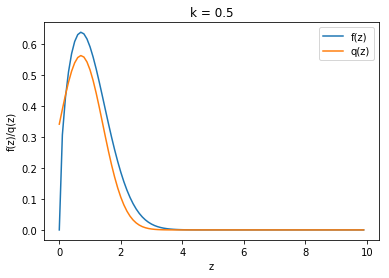

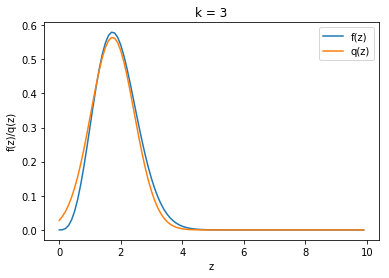

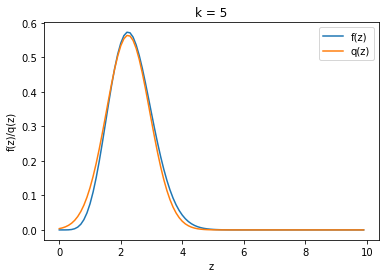

In [18]:
N = 100
a = 10
ks = (0.5, 3, 5)
# approximation_x = list()
A = 2
for k in ks:
    y = list ()
    x = list ()
    approximation_y = list()
    for z in np.arange (0, a, a/N):
        x.append (z)
        # f (x) -- the function given to us
        y.append ((z**k)*np.exp(-(z**2)/2))
        # q (x) -- our laplace approximation
        approximation_y.append (np.sqrt(A/(2*np.pi))*np.exp (-(A/2)*(z-np.sqrt(k))**2))
    normalisation_factor = sum (y)*a/N
    print ("normalisation factor", format (normalisation_factor, ".5f"))
    plt.plot (x, 1/normalisation_factor * np.array(y), label = "f(z)")
    plt.plot (x, approximation_y, label = "q(z)")
    plt.title ("k = " + str(k))
    plt.xlabel ("z")
    plt.ylabel ("f(z)/q(z)")
    plt.legend()
    plt.figure()
    mse = np.mean ((np.array(y/normalisation_factor) - np.array(approximation_y))**2)
    print ("z = " + str (k) + " -> " + str (mse))

> Having a $z > 5$ results in very small values for $f(z)$ and $q (z)$ hence the value is converging to $0$ as $x$ gets closer to $\infty$.